# Application for TSAS - Optimisation

This document has been published for reproducing the application presented in a conference paper dedicated to AeroMAPS, focuding on the reproduction of ICAO LTAG scenarios. The different assumptions of this prospective scenario are given in the following. 

> **⚠ This notebook has been developed with the AeroMAPS version v0.7.1-beta for obtaining the paper results. However, this notebook has been or could be modified in order to be executable with the latest versions of AeroMAPS, which sometimes leads to different results compared to the ones from the paper, due to some models' modifications. In order to retrieve the results of the paper, one can use the v0.4.2-beta version associated with the original notebook.**

This notebook extends the main examples_tsas_application by introducing a secario optimisation.

## Load

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
from aeromaps import create_process
from aeromaps.core.models import (
    models_traffic,
    models_efficiency_top_down_interp,
    models_energy_with_fuel_effect,
    models_offset,
    models_climate_fair,
    models_climate_gwpstar,
    models_energy_cost_complex,
    models_operation_cost_top_down,
    models_abatements_cost_simplified,
    models_optim_tsas_custom,
    models_sustainability,
)
from aeromaps.utils.functions import create_partitioning, merge_json_files

import gemseo as gm
import json

gm.configure_logger()

<RootLogger root (INFO)>

## Partitioning for international aviation

In [2]:
create_partitioning(
    file="data_tsas/data_tsas_optim/aeroscope_international_data.csv",
    path="data_tsas/data_tsas_optim",
)

## Models

In [3]:
models = {
    "models_traffic": models_traffic,
    "models_efficiency_top_down_interp": models_efficiency_top_down_interp,
    "models_energy_with_fuel_effect": models_energy_with_fuel_effect,
    "models_offset": models_offset,
    "models_climate_gwpstar": models_climate_gwpstar,
    "models_energy_cost_complex": models_energy_cost_complex,
    "models_operation_cost_top_down": models_operation_cost_top_down,
    "models_abatements_cost_simplified": models_abatements_cost_simplified,
    "models_optim_tsas_custom": models_optim_tsas_custom,
    "models_sustainability": models_sustainability,
}

## Process, data and compute

In [4]:
merge_json_files(
    "data_tsas/data_tsas_optim/partitioned_inputs.json",
    "data_tsas/data_tsas_optim/is2medium_inputs.json",
    "data_tsas/data_tsas_optim/partitioned_is2medium_inputs.json",
)

In [5]:
process_is2medium = create_process(
    configuration_file="data_tsas/data_tsas_optim/config_is2medium.json", models=models
)

In [6]:
international_ask_share = 66.35 / 100

process_is2medium.parameters.aviation_carbon_budget_objective = (
    3.6 * international_ask_share
)  # --> sensitivity 4.8

process_is2medium.parameters.biomass_availability_constraint_trajectory_reference_years = [
    2020,
    2030,
    2040,
    2050,
]
process_is2medium.parameters.biomass_availability_constraint_trajectory_reference_years_values = [
    62.8 * international_ask_share,
    72.1 * international_ask_share,
    97.8 * international_ask_share,
    101.8 * international_ask_share,
]

process_is2medium.parameters.electricity_availability_constraint_trajectory_reference_years = [
    2020,
    2030,
    2040,
    2050,
]
process_is2medium.parameters.electricity_availability_constraint_trajectory_reference_years_values = [
    102.0456 * international_ask_share,
    137.5452 * international_ask_share,
    212.7996 * international_ask_share,
    276.6168 * international_ask_share,
]

process_is2medium.parameters.volume_ramp_up_constraint_biofuel = 0.3 * international_ask_share
process_is2medium.parameters.rate_ramp_up_constraint_biofuel = 0.2

process_is2medium.parameters.volume_ramp_up_constraint_electrofuel = 0.3 * international_ask_share
process_is2medium.parameters.rate_ramp_up_constraint_electrofuel = 0.2

## Carbon budgets and Carbon Dioxide Removal [GtCO2]
process_is2medium.parameters.net_carbon_budget = 850.0
process_is2medium.parameters.carbon_dioxyde_removal_2100 = 285.0


# Allocation settings

## Aviation share of the global (equivalent) carbon budget [%]
process_is2medium.parameters.aviation_carbon_budget_allocated_share = 3.6
process_is2medium.parameters.aviation_equivalentcarbonbudget_allocated_share = 5.1

## Aviation share of the global energy resources (biomass and electricity) [%]
process_is2medium.parameters.aviation_biomass_allocated_share = 15.0
process_is2medium.parameters.aviation_electricity_allocated_share = 8.0


### Biofuel and efuel reference years associated with the optim variables

process_is2medium.parameters.biofuel_share_reference_years = [2030, 2035, 2040, 2045, 2050]
process_is2medium.parameters.electrofuel_share_reference_years = [2030, 2035, 2040, 2045, 2050]

### Optimisation problem setup with GEMSEO

In [7]:
from gemseo.algos.design_space import DesignSpace

from gemseo.algos.opt.nlopt.settings.nlopt_cobyla_settings import NLOPT_COBYLA_Settings

process_is2medium.setup()

# Create a GEMSEO scenario

process_is2medium.gemseo_settings["scenario_type"] = "MDO"


# define the design sapce: electrofuel and biofuel blending mandates

design_space = DesignSpace()
design_space.add_variable(
    "electrofuel_share_reference_years_values",
    size=5,
    lower_bound=[1e-17, 1e-17, 1e-17, 1e-17, 1e-17],
    upper_bound=[100, 100, 100, 100, 100],
    value=[9.13249637, 14.68171346, 24.29143904, 41.14065492, 41.87052262],
)

design_space.add_variable(
    "biofuel_share_reference_years_values",
    size=5,
    lower_bound=[1e-17, 1e-17, 1e-17, 1e-17, 1e-17],
    upper_bound=[100, 100, 100, 100, 100],
    value=[10.85689249, 16.98435693, 29.28238527, 32.74786858, 29.99980536],
)


process_is2medium.gemseo_settings["design_space"] = design_space


# Define the objective
objective_name = "cumulative_total_airline_cost_discounted_obj"
process_is2medium.gemseo_settings["objective_name"] = objective_name


process_is2medium.create_gemseo_scenario()
# Make optimisation objective values in the 1-10 interval
process_is2medium.scenario.formulation.optimization_problem.objective = (
    process_is2medium.scenario.formulation.optimization_problem.objective * 1e-13
)


# Add constraints
all_constraints = [
    "aviation_carbon_budget_constraint",
    "blend_completeness_constraint",
    "electricity_trajectory_constraint",
    "biomass_trajectory_constraint",
    "electrofuel_use_growth_constraint",
    "biofuel_use_growth_constraint",
    "biofuel_use_no_degrowth_constraint",
    "electrofuel_use_no_degrowth_constraint",
]


for constraint in all_constraints:
    process_is2medium.scenario.add_constraint(constraint, constraint_type="ineq")


process_is2medium.scenario.set_differentiation_method("finite_differences")

# Optim algo: COBYLA, a gradient-free non linear solver
cobyla_settings = NLOPT_COBYLA_Settings(
    max_iter=200,
    ftol_rel=0.001,
    ftol_abs=0.001,
    ineq_tolerance=0.015,
    normalize_design_space=True,
    init_step=0.1,
)

process_is2medium.gemseo_settings["algorithm"] = cobyla_settings

 WARNING - 17:41:32: No coupling in MDA, switching chain_linearize to True.


In [8]:
import warnings

warnings.filterwarnings("ignore")
process_is2medium.compute()

    INFO - 17:41:32:  
    INFO - 17:41:32: *** Start MDOScenario execution ***
    INFO - 17:41:32: MDOScenario
    INFO - 17:41:32:    Disciplines: MDAChain
    INFO - 17:41:32:    MDO formulation: MDF
    INFO - 17:41:32: Optimization problem:
    INFO - 17:41:32:    minimize 1e-13*cumulative_total_airline_cost_discounted_obj(electrofuel_share_reference_years_values, biofuel_share_reference_years_values)
    INFO - 17:41:32:    with respect to biofuel_share_reference_years_values, electrofuel_share_reference_years_values
    INFO - 17:41:32:    subject to constraints:
    INFO - 17:41:32:       aviation_carbon_budget_constraint(electrofuel_share_reference_years_values, biofuel_share_reference_years_values) <= 0
    INFO - 17:41:32:       blend_completeness_constraint(electrofuel_share_reference_years_values, biofuel_share_reference_years_values) <= 0
    INFO - 17:41:32:       electricity_trajectory_constraint(electrofuel_share_reference_years_values, biofuel_share_reference_years_v

Running MDO


    INFO - 17:42:35:     16%|█▌        | 32/200 [01:03<05:30, 30.46 it/min, obj=3.12]
    INFO - 17:42:35: Optimization result:
    INFO - 17:42:35:    Optimizer info:
    INFO - 17:42:35:       Status: None
    INFO - 17:42:35:       Message: Successive iterates of the objective function are closer than ftol_rel or ftol_abs. GEMSEO stopped the driver.
    INFO - 17:42:35:       Number of calls to the objective function by the optimizer: 33
    INFO - 17:42:35:    Solution:
    INFO - 17:42:35:       The solution is feasible.
    INFO - 17:42:35:       Objective: 3.1112532781970996
    INFO - 17:42:35:       Standardized constraints:
    INFO - 17:42:35:          aviation_carbon_budget_constraint = 0.013122414549187679
    INFO - 17:42:35:          biofuel_use_growth_constraint = -0.0722308058910769
    INFO - 17:42:35:          biofuel_use_no_degrowth_constraint = -0.0053094322540580465
    INFO - 17:42:35:          biomass_trajectory_constraint = -0.004780700947064109
    INFO - 17:4

## Results

In [9]:
process = process_is2medium

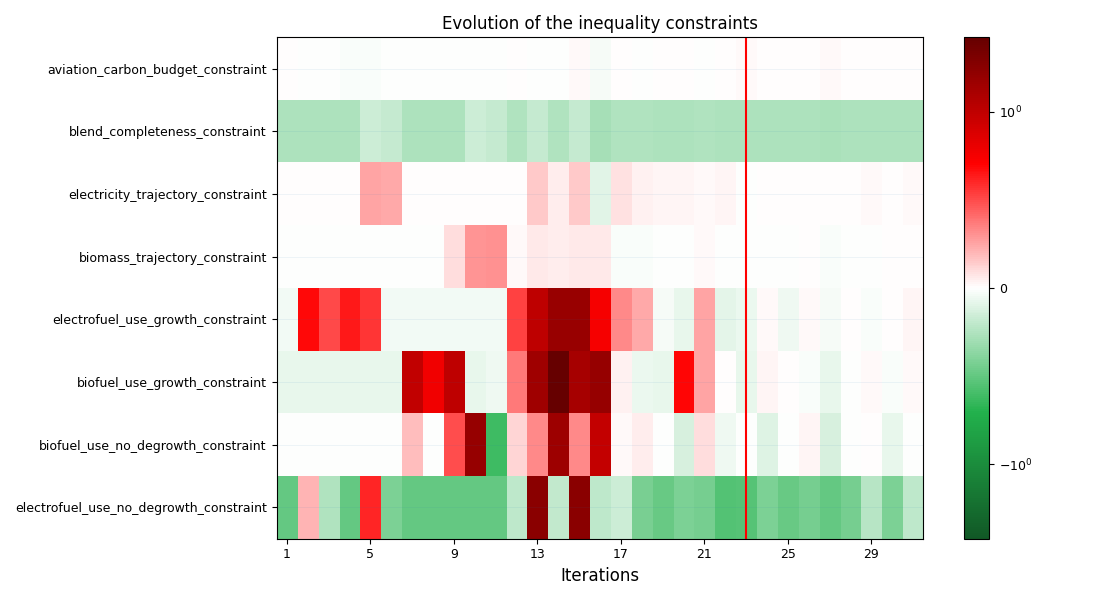

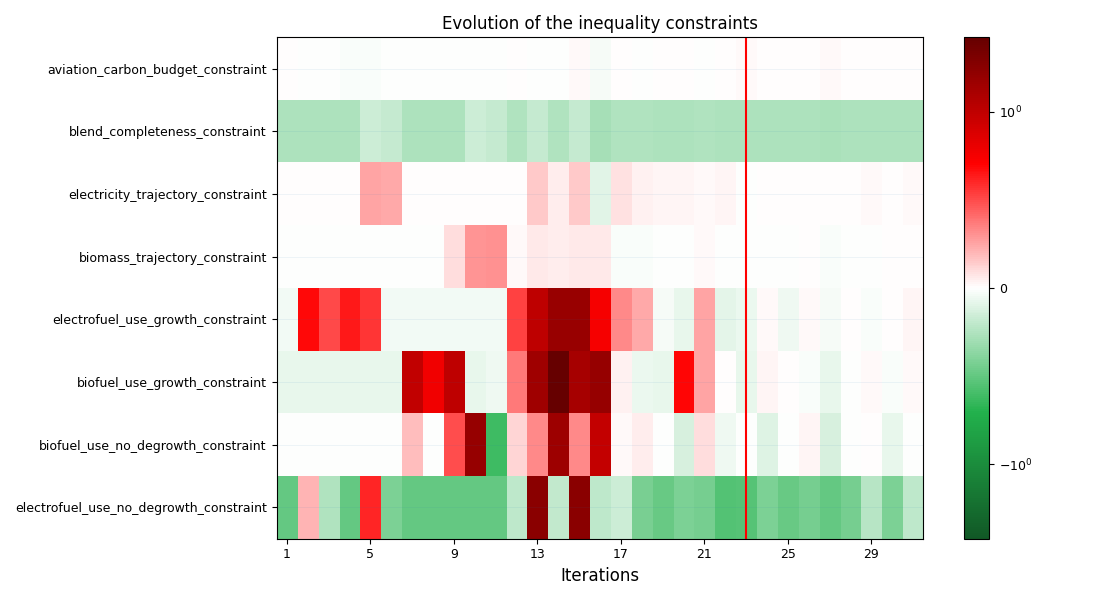

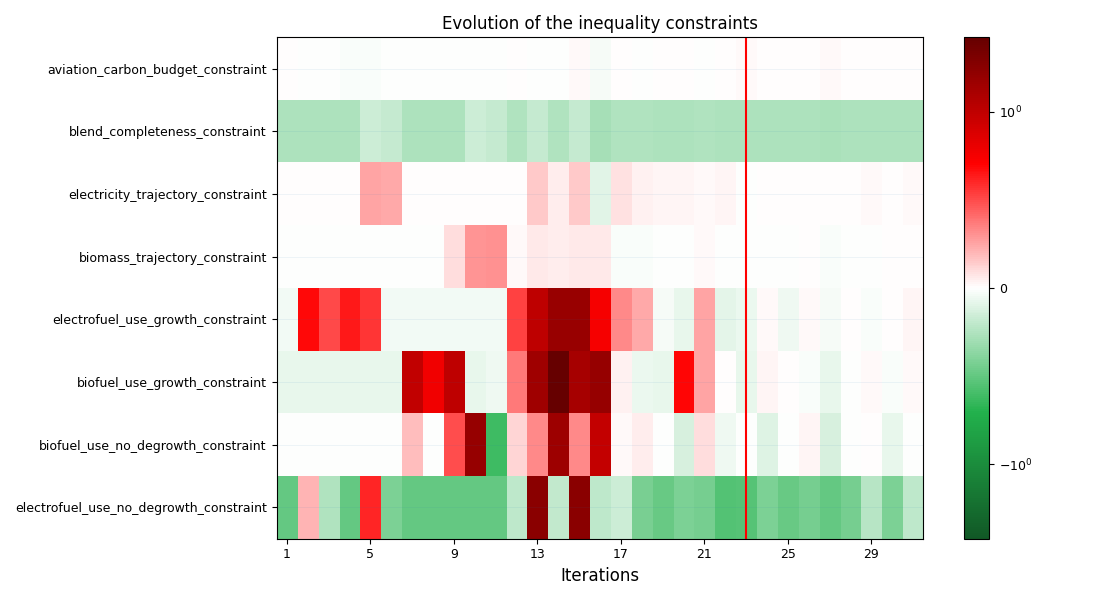

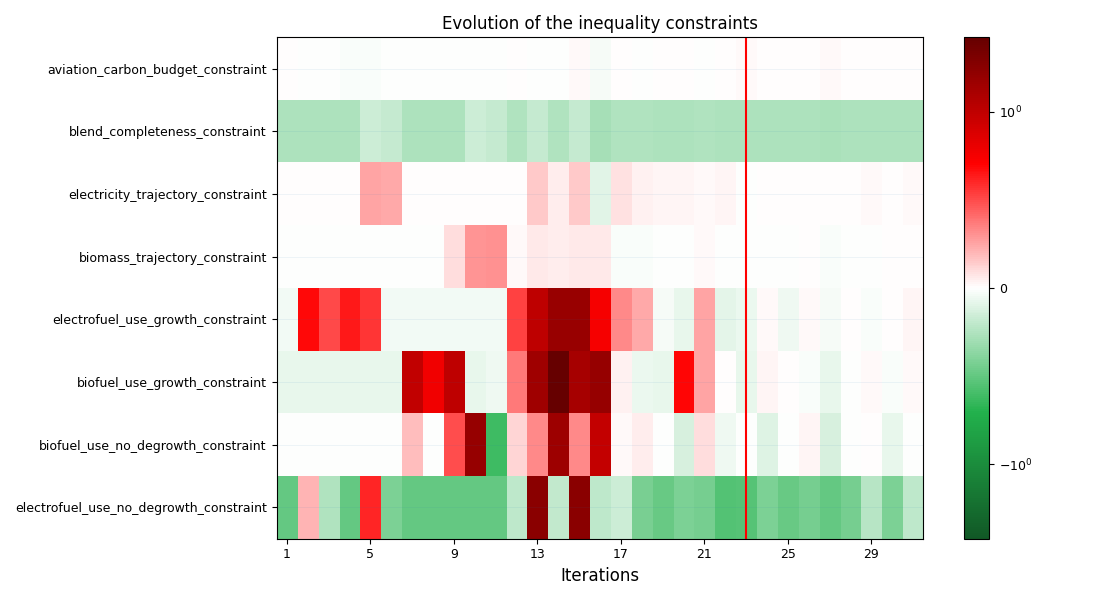

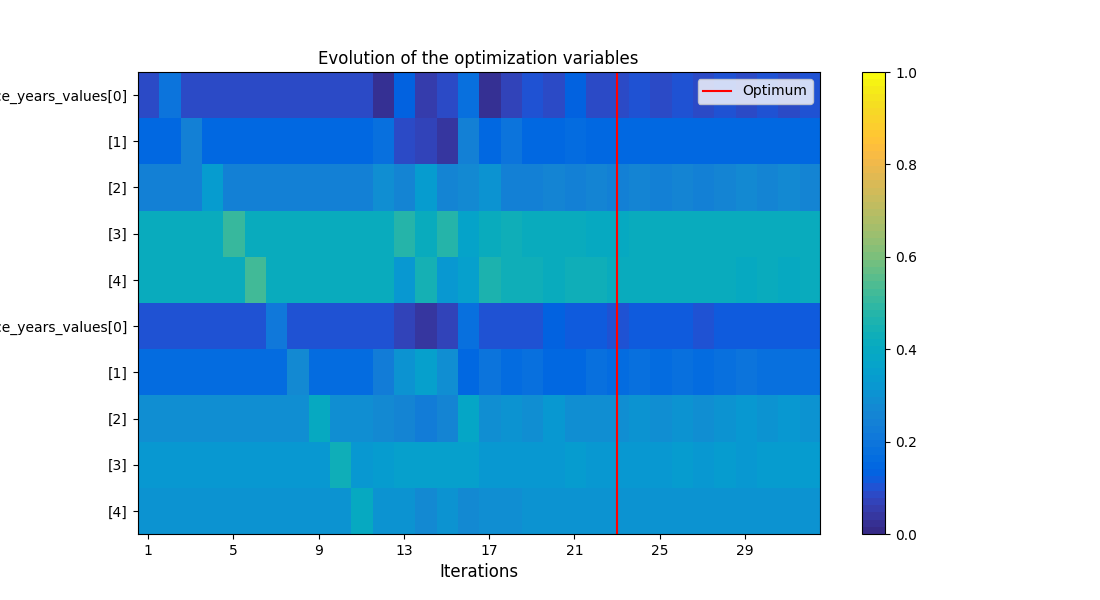

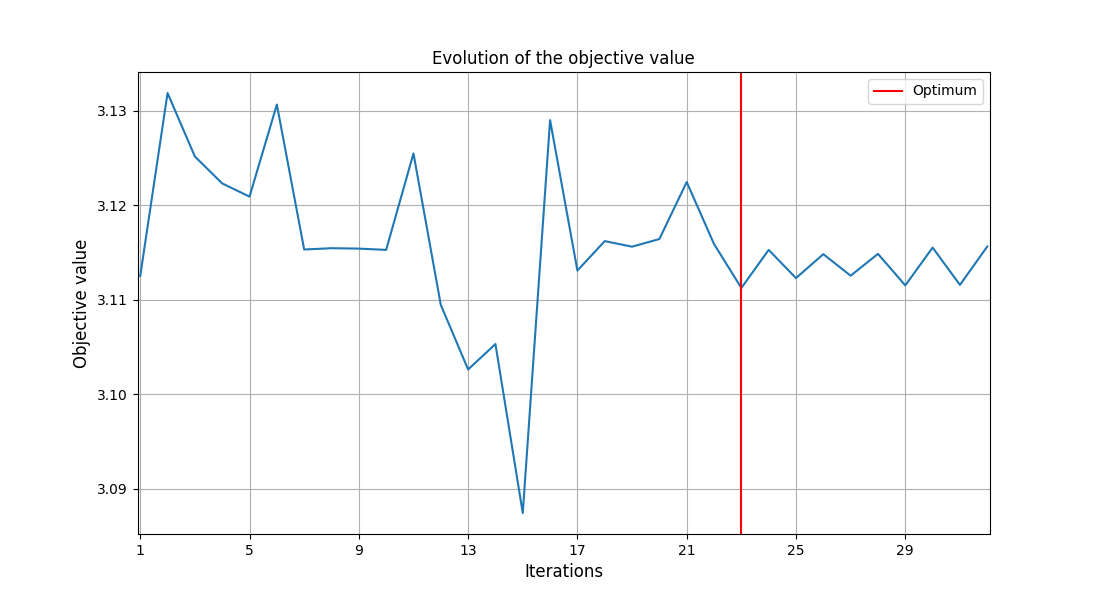

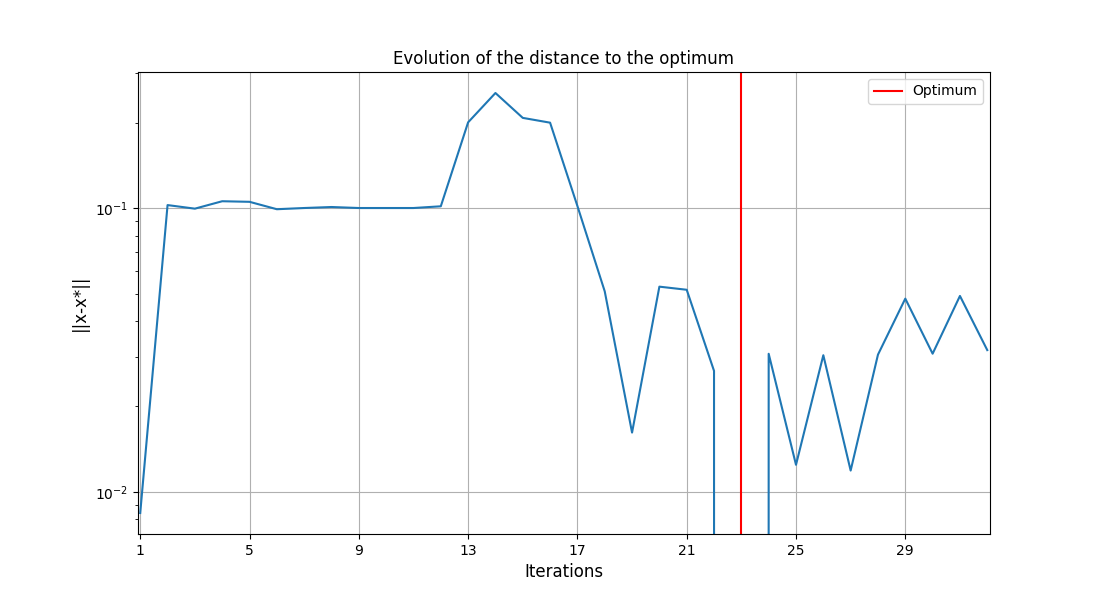

In [10]:
from gemseo import execute_post

process_is2medium.scenario.post_process(
    post_name="OptHistoryView",
    constraint_names=all_constraints,
    save=False,
    show=True,
)

In [11]:
process.scenario.get_result().design_variable_names_to_values

{'electrofuel_share_reference_years_values': array([ 8.88667811, 14.73457392, 23.70502443, 40.60727634, 41.96874507]),
 'biofuel_share_reference_years_values': array([10.85689249, 16.90164803, 29.28238527, 32.74786858, 29.99980536])}

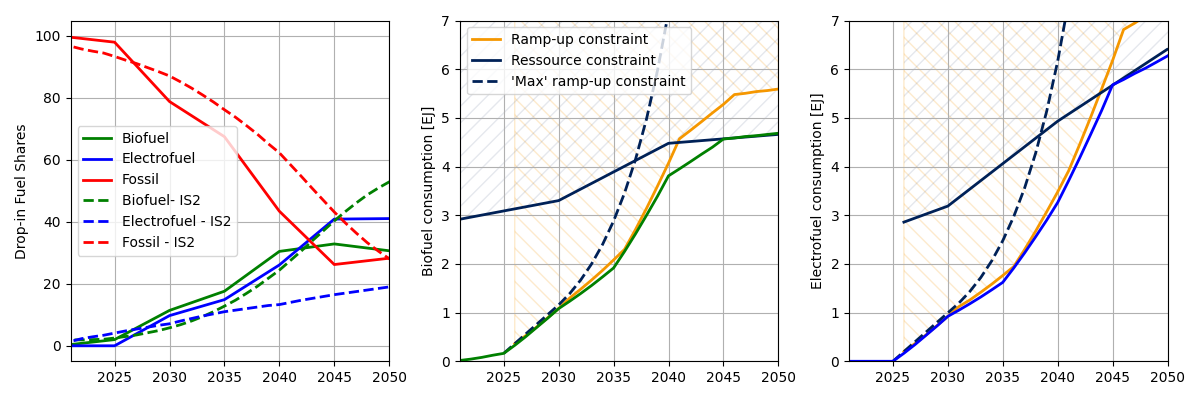

In [12]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(12, 4))

ax1.plot(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[process.data["years"]["prospective_years"], "biofuel_share"],
    color="green",
    linestyle="-",
    label="Biofuel",
    linewidth=2,
)

ax1.plot(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[process.data["years"]["prospective_years"], "electrofuel_share"],
    color="blue",
    linestyle="-",
    label="Electrofuel",
    linewidth=2,
)

ax1.plot(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[process.data["years"]["prospective_years"], "kerosene_share"],
    color="red",
    linestyle="-",
    label="Fossil",
    linewidth=2,
)


ax1.plot(
    [
        2020,
        2021,
        2022,
        2023,
        2024,
        2025,
        2026,
        2027,
        2028,
        2029,
        2030,
        2031,
        2032,
        2033,
        2034,
        2035,
        2036,
        2037,
        2038,
        2039,
        2040,
        2041,
        2042,
        2043,
        2044,
        2045,
        2046,
        2047,
        2048,
        2049,
        2050,
        2051,
        2052,
        2053,
        2054,
        2055,
        2056,
        2057,
        2058,
        2059,
        2060,
        2061,
        2062,
        2063,
        2064,
        2065,
        2066,
        2067,
        2068,
        2069,
        2070,
    ],
    [
        2.0,
        1.9,
        1.9,
        2.0,
        2.1,
        2.5,
        3.0,
        3.5,
        4.2,
        4.9,
        5.8,
        6.8,
        8.0,
        9.4,
        11.0,
        12.8,
        14.7,
        16.9,
        19.2,
        21.8,
        24.4,
        27.5,
        30.6,
        33.9,
        37.1,
        40.3,
        43.3,
        46.1,
        48.7,
        50.9,
        52.9,
        54.3,
        55.4,
        56.1,
        56.6,
        56.9,
        56.9,
        56.8,
        56.5,
        56.1,
        55.6,
        54.6,
        53.7,
        52.7,
        51.8,
        50.8,
        49.9,
        48.9,
        48.0,
        47.1,
        46.2,
    ],
    color="green",
    linestyle="--",
    label="Biofuel- IS2",
    linewidth=2,
)

ax1.plot(
    [
        2020,
        2021,
        2022,
        2023,
        2024,
        2025,
        2026,
        2027,
        2028,
        2029,
        2030,
        2031,
        2032,
        2033,
        2034,
        2035,
        2036,
        2037,
        2038,
        2039,
        2040,
        2041,
        2042,
        2043,
        2044,
        2045,
        2046,
        2047,
        2048,
        2049,
        2050,
        2051,
        2052,
        2053,
        2054,
        2055,
        2056,
        2057,
        2058,
        2059,
        2060,
        2061,
        2062,
        2063,
        2064,
        2065,
        2066,
        2067,
        2068,
        2069,
        2070,
    ],
    [
        0.0,
        1.4,
        2.3,
        2.9,
        3.4,
        4.1,
        4.8,
        5.4,
        6.0,
        6.6,
        7.1,
        8.0,
        8.8,
        9.6,
        10.3,
        11.0,
        11.5,
        12.0,
        12.5,
        13.0,
        13.3,
        14.0,
        14.7,
        15.3,
        15.9,
        16.5,
        17.0,
        17.5,
        18.0,
        18.5,
        19.0,
        18.2,
        17.8,
        17.6,
        17.7,
        18.0,
        18.5,
        19.1,
        19.9,
        20.7,
        21.7,
        23.2,
        24.6,
        26.1,
        27.6,
        29.0,
        30.4,
        31.8,
        33.1,
        34.4,
        35.7,
    ],
    color="blue",
    linestyle="--",
    label="Electrofuel - IS2",
    linewidth=2,
)

ax1.plot(
    [
        2020,
        2021,
        2022,
        2023,
        2024,
        2025,
        2026,
        2027,
        2028,
        2029,
        2030,
        2031,
        2032,
        2033,
        2034,
        2035,
        2036,
        2037,
        2038,
        2039,
        2040,
        2041,
        2042,
        2043,
        2044,
        2045,
        2046,
        2047,
        2048,
        2049,
        2050,
        2051,
        2052,
        2053,
        2054,
        2055,
        2056,
        2057,
        2058,
        2059,
        2060,
        2061,
        2062,
        2063,
        2064,
        2065,
        2066,
        2067,
        2068,
        2069,
        2070,
    ],
    [
        98.0,
        96.7,
        95.8,
        95.1,
        94.5,
        93.4,
        92.2,
        91.1,
        89.8,
        88.5,
        87.1,
        85.2,
        83.2,
        81.0,
        78.7,
        76.2,
        73.8,
        71.1,
        68.3,
        65.2,
        62.3,
        58.5,
        54.7,
        50.8,
        47.0,
        43.2,
        39.7,
        36.4,
        33.3,
        30.6,
        28.1,
        27.5,
        26.8,
        26.3,
        25.7,
        25.1,
        24.6,
        24.1,
        23.6,
        23.2,
        22.7,
        22.2,
        21.7,
        21.2,
        20.6,
        20.2,
        19.7,
        19.3,
        18.9,
        18.5,
        18.1,
    ],
    color="red",
    linestyle="--",
    label="Fossil - IS2",
    linewidth=2,
)


ax1.grid()
ax1.legend()
ax1.set_ylabel("Drop-in Fuel Shares")
ax1.set_xlim(2021, 2050)


ax2.plot(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[
        process.data["years"]["prospective_years"], "annual_biofuel_growth_constraint_viz"
    ]
    / 1e12,
    color="#F59700",
    linestyle="-",
    label="Ramp-up constraint",
    linewidth=2,
)

ax2.fill_between(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[
        process.data["years"]["prospective_years"], "annual_biofuel_growth_constraint_viz"
    ]
    / 1e12,
    10,
    hatch="\\\\",
    edgecolor="#F59700",
    facecolor="none",
    alpha=0.2,
)


ax2.plot(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[
        process.data["years"]["prospective_years"], "biofuel_max_availability_viz"
    ]
    / 1e12,
    color="#002157",
    linestyle="-",
    label="Ressource constraint",
    linewidth=2,
)

ax2.fill_between(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[
        process.data["years"]["prospective_years"], "biofuel_max_availability_viz"
    ]
    / 1e12,
    10,
    hatch="//",
    edgecolor="#002157",
    facecolor="none",
    linewidth=0,
    alpha=0.1,
)


ax2.plot(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[
        process.data["years"]["prospective_years"], "biofuel_growth_constraint_theoretical_max_viz"
    ]
    / 1e12,
    color="#002157",
    linestyle="--",
    label="'Max' ramp-up constraint",
    linewidth=2,
)


ax2.plot(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[
        process.data["years"]["prospective_years"], "energy_consumption_biofuel"
    ]
    / 1e12,
    color="green",
    linestyle="-",
    # label="Aviation biofuel consumption",
    linewidth=2,
)


ax2.grid()
# ax2.set_xlabel("Year")
ax2.set_ylabel("Biofuel consumption [EJ]")
ax2.legend(loc="upper left")
ax2.set_xlim(2021, 2050)
ax2.set_ylim(0, 7)


ax3.plot(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[
        process.data["years"]["prospective_years"], "annual_electrofuel_growth_constraint_viz"
    ]
    / 1e12,
    color="#F59700",
    linestyle="-",
    # label="Electrofuel ramp-up constraint",
    linewidth=2,
)

ax3.fill_between(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[
        process.data["years"]["prospective_years"], "annual_electrofuel_growth_constraint_viz"
    ]
    / 1e12,
    10,
    hatch="\\\\",
    edgecolor="#F59700",
    facecolor="none",
    alpha=0.2,
)


ax3.plot(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[
        process.data["years"]["prospective_years"], "electrofuel_max_availability_viz"
    ]
    / 1e12,
    color="#002157",
    linestyle="-",
    # label="Electricity availability constraint",
    linewidth=2,
)

ax3.fill_between(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[
        process.data["years"]["prospective_years"], "electrofuel_max_availability_viz"
    ]
    / 1e12,
    10,
    hatch="//",
    edgecolor="#002157",
    facecolor="none",
    linewidth=0,
    alpha=0.1,
)


ax3.plot(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[
        process.data["years"]["prospective_years"],
        "electrofuel_growth_constraint_theoretical_max_viz",
    ]
    / 1e12,
    color="#002157",
    linestyle="--",
    # label="Electrofuel theoretical max ramp-Up constraint",
    linewidth=2,
)


ax3.plot(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[
        process.data["years"]["prospective_years"], "energy_consumption_electrofuel"
    ]
    / 1e12,
    color="blue",
    linestyle="-",
    # label="Aviation electrofuel consumption",
    linewidth=2,
)


ax3.grid()
ax3.set_ylabel("Electrofuel consumption [EJ]")
ax3.set_xlim(2021, 2050)
ax3.set_ylim(0, 7)

fig.tight_layout()
fig.savefig("ressource_constraints.png", dpi=800)